In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, Layer, Input, MaxPool2D, Flatten, BatchNormalization, Dense,Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
dataset, dataset_info = tfds.load(
    'malaria', with_info=True,
    as_supervised=True,
    shuffle_files = True,
    split=['train']
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.I6QPO3_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

In [ ]:
IM_size = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_size, IM_size))/255, label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_size, IM_size, 3)),

    Conv2D(2, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(4, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(0.25),

    Conv2D(8, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
])
feature_extractor_seq_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 2)    │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 4)    │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 4)    │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,716 (6.70 KB)

 Trainable params: 1,656 (6.47 KB)

 Non-trainable params: 60 (240.00 B)

In [ ]:
func_input = Input(shape=(IM_size, IM_size, 3),name = 'Input Image')
x = feature_extractor_seq_model(func_input)
x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)   # 🔹 most important dropout (FC layers overfit easily)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)
alexnet_model = Model(inputs=func_input, outputs=func_output,name = "alexNet_Model")
alexnet_model.summary()

Model: "alexNet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 12, 12, 16)     │         1,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       230,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,677 (912.80 KB)

 Trainable params: 233,397 (911.71 KB)

 Non-trainable params: 280 (1.09 KB)

Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
    super(FeatureExtractor,self).__init__()

    self.conv_1 = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_2 = Conv2D(2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 =BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)
    self.drop_2 = Dropout(0.25)

    self.conv_3 = Conv2D(4*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_3 =BatchNormalization()
    self.pool_3 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_4 = Conv2D(8*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_4 =BatchNormalization()
    self.pool_4 = MaxPool2D(pool_size=pool_size, strides=2*strides)
  def call(self,x,training = False):
    x = self.conv_1(x)
    x = self.batch_1(x,training = training)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = self.batch_2(x,training = training)
    x = self.pool_2(x)
    x = self.drop_2(x)
    x = self.conv_3(x)
    x = self.batch_3(x,training = training)
    x = self.pool_3(x)
    x = self.conv_4(x)
    x = self.batch_4(x,training = training)
    x = self.pool_4(x)
    return x
feature_extractor_model = FeatureExtractor(2,3,1,'valid','relu',2)


In [ ]:
class AlexNetModel(Model):
  def __init__(self):
    super(AlexNetModel,self).__init__()
    self.feature_extractor = FeatureExtractor(2,3,1,'valid','relu',2)
    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation='relu')
    self.batch_1 = BatchNormalization()
    self.drop_1 = Dropout(0.6)

    self.dense_2 = Dense(10, activation='relu')
    self.batch_2 = BatchNormalization()
    self.dense_3 = Dense(1, activation='sigmoid')
  def call(self,x,training = False):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x,training = training)
    x = self.drop_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x,training = training)
    x = self.dense_3(x)
    return x
alexnet_sub_model = AlexNetModel()
alexnet_sub_model(tf.zeros([1,224,224,3]))
alexnet_sub_model.summary()

Model: "alex_net_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extractor_1             │ ?                      │         1,716 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (1, 2304)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 100)               │       230,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (1, 100)               │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 10)                │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (1, 10)                │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 1)                 │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,677 (912.80 KB)

 Trainable params: 233,397 (911.71 KB)

 Non-trainable params: 280 (1.09 KB)

CUSTOM LAYER

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self,output_units,activation):
    super(NeuralearnDense,self).__init__()
    self.output_units = output_units
    self.activation = activation
  def build(self,input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1],self.output_units),initializer = "random_normal",trainable = True)
    self.b = self.add_weight(shape = (self.output_units,),initializer = "random_normal",trainable = True)

  def call(self,input_features):
    pre_output = tf.matmul(input_features,self.w) + self.b
    if(self.activation == 'relu'):
      return tf.nn.relu(pre_output)
    elif(self.activation == 'sigmoid'):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output


In [ ]:
IM_size = 224
AlexNet_custom_model = Sequential([
    InputLayer(input_shape=(IM_size, IM_size, 3)),

    Conv2D(2, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(4, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(0.25),

    Conv2D(8, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),

    NeuralearnDense(100, activation='relu'),
    BatchNormalization(),
    Dropout(0.6),    # 🔹 most important dropout (FC layers overfit easily)

    NeuralearnDense(10, activation='relu'),
    BatchNormalization(),
    NeuralearnDense(1, activation='sigmoid')
])
AlexNet_custom_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 222, 222, 2)    │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 4)    │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 109, 109, 4)    │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 54, 54, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 52, 52, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense                │ (None, 100)            │       230,500 │
│ (NeuralearnDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense_1              │ (None, 10)             │         1,010 │
│ (NeuralearnDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense_2              │ (None, 1)              │            11 │
│ (NeuralearnDense)               │                        │               │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 233,677 (912.80 KB)

 Trainable params: 233,397 (911.71 KB)

 Non-trainable params: 280 (1.09 KB)

In [ ]:
metrics = [TruePositives(name = 'tp'),FalsePositives(name = 'fp'),TrueNegatives(name = 'tn'),FalseNegatives(name = 'fn'),
           BinaryAccuracy(name = 'accuracy'),Precision(name = 'precision'),Recall(name = 'recall'),AUC(name = 'auc')]

In [ ]:
AlexNet_custom_model.compile(optimizer=Adam(learning_rate=0.001),
                             loss=BinaryCrossentropy(),
                             metrics=metrics)

In [ ]:
history = AlexNet_custom_model.fit(train_dataset,
                                      validation_data=val_dataset,
                                      epochs=3,verbose =1)

Epoch 1/3
689/689 ━━━━━━━━━━━━━━━━━━━━ 61s 72ms/step - accuracy: 0.7921 - auc: 0.8639 - fn: 900.6812 - fp: 899.8449 - loss: 0.4520 - precision: 0.7943 - recall: 0.7972 - tn: 4618.8667 - tp: 4636.5552 - val_accuracy: 0.9441 - val_auc: 0.9813 - val_fn: 39.0000 - val_fp: 115.0000 - val_loss: 0.1780 - val_precision: 0.9218 - val_recall: 0.9720 - val_tn: 1245.0000 - val_tp: 1356.0000
Epoch 2/3
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.9421 - auc: 0.9750 - fn: 269.7130 - fp: 374.4565 - loss: 0.1805 - precision: 0.9341 - recall: 0.9521 - tn: 5144.2437 - tp: 5267.5347 - val_accuracy: 0.9554 - val_auc: 0.9831 - val_fn: 49.0000 - val_fp: 74.0000 - val_loss: 0.1470 - val_precision: 0.9479 - val_recall: 0.9649 - val_tn: 1285.0000 - val_tp: 1347.0000
Epoch 3/3
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.9473 - auc: 0.9776 - fn: 239.6015 - fp: 363.0145 - loss: 0.1669 - precision: 0.9386 - recall: 0.9581 - tn: 5155.8218 - tp: 5297.5103 - val_accuracy: 0.9564 - val_auc: 0.9

In [ ]:
AlexNet_custom_model.predict(test_dataset.take(1).batch(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


np.float32(0.84092075)

In [ ]:
def parasite_or_not(x):
  if x<0.5:
    return str('P')
  else:
    return str('U')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


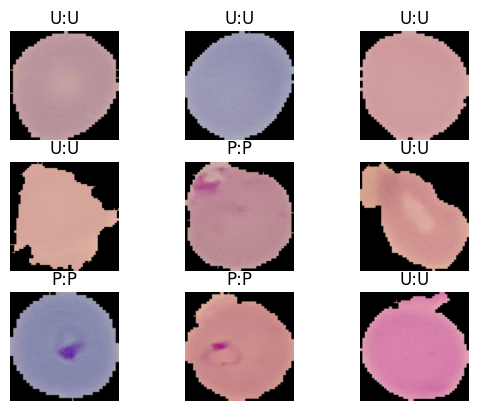

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax=plt.subplot(3,3,i+1)

  plt.imshow(image)
  plt.title(str(parasite_or_not(label.numpy())) + ":" +str(parasite_or_not(AlexNet_custom_model.predict(tf.expand_dims(image, axis=0))[0][0])))
  plt.axis('off')

Model Evaluation and Testing

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
AlexNet_custom_model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9517 - auc: 0.9836 - fn: 23.8263 - fp: 42.9286 - loss: 0.1512 - precision: 0.9394 - recall: 0.9669 - tn: 644.3350 - tp: 668.4097


[0.15698309242725372,
 1313.0,
 84.0,
 1308.0,
 52.0,
 0.9506710171699524,
 0.9398711323738098,
 0.961904764175415,
 0.982854962348938]

Visuakizing Confussion Matrix

In [ ]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [ ]:
labels = np.array([i[0] for i in labels])
print(labels)

[1 0 0 ... 0 1 1]


In [ ]:
predicted = AlexNet_custom_model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[0.8409208  0.01208111 0.02464769 ... 0.04014308 0.9700514  0.9566353 ]


[[1310   82]
 [  57 1308]]


Text(0.5, 58.7222222222222, 'Predicted')

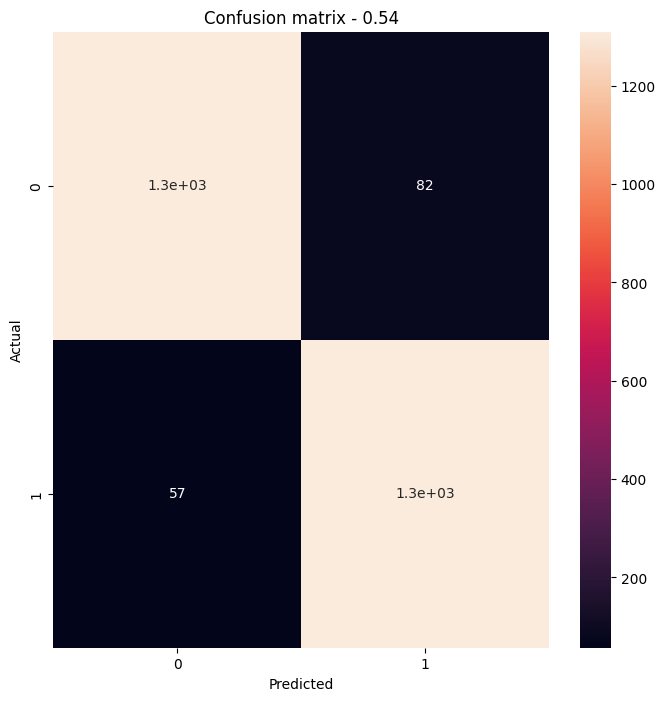

In [ ]:
threshold = 0.54

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

ROC plots

In [ ]:
len(thresholds)

224

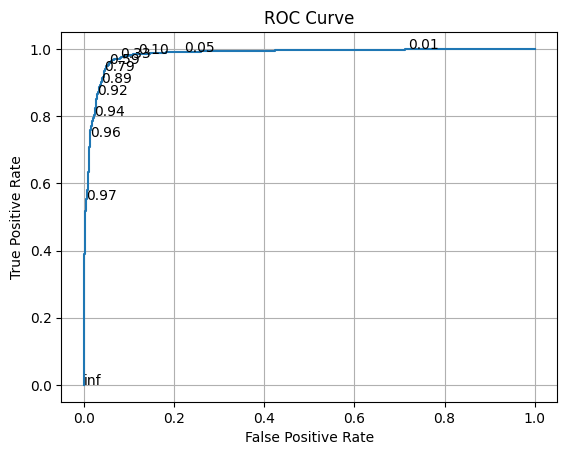

In [ ]:
fp,tp,thresholds = roc_curve(labels,predicted)
plt.plot(fp,tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
skip = 20
for i in range(0,len(thresholds),skip):
  plt.text(fp[i],tp[i],f'{thresholds[i]:.2f}')
plt.show()